## Решение СЛАУ с плотными матрицами

In [1]:
import numpy as np

Рассмотрим интегральное уравнение Фредгольма второго рода

$$
u(x) - \lambda \int_{-\pi}^{\pi} K(y-x) u(y) dy = f(x)\\
K(s) = |s|, \qquad f(x) = (1 + 2 \lambda) \cos^2 \frac{x}{2} - \frac{\lambda}{2} (x^2 + \pi^2)
$$
Здесь $u(x)$ &mdash; неизвестная функция, $\lambda$ &mdash; параметр. Правая часть подобрана так, чтобы точное решение было неизменно $U(x) = \cos^2 \frac{x}{2}$

In [2]:
# Описание математической задачи. Суффикс _fun нужен, чтобы имена этих функций
# не путались с именем матрицы и правой части

def K_fun(s):
    return abs(s)

def f_fun(x, lam):
    return (1 + 2 * lam) * np.cos(x/2)**2 - lam*(x*x + np.pi*np.pi) / 2

def U_fun(x):
    return np.cos(x/2)**2

<img src="grid.png" />

Построим на $[-\pi, \pi]$ равномерную сетку из $N$ интервалов длины $h = \frac{2\pi}{N}$ и заменим интеграл по формуле средней точки:
$$
u(x) - \lambda h \sum_{i=\frac{1}{2}, \frac{3}{2}, \dots, N-\frac{1}{2}} K(x_i - x) u(x_i) = f(x).
$$
Здесь $x_{i+1/2}$ &mdash; центр интервала $[x_i, x_{i+1}]$, а $x_i = -\pi + i h, \quad i = 0, 1, \dots, N$.

Потребуем, чтобы уравнение выполнялось не при любых $x$, а лишь в центрах отрезков (в так называемых *точках коллокации*) $x_j, \quad j = \frac{1}{2}, \frac{3}{2}, \dots, N-\frac{1}{2}$:
$$
u(x_j) - \lambda h \sum_{i=\frac{1}{2}, \frac{3}{2}, \dots, N-\frac{1}{2}} K(x_i - x_j) u(x_i) = f(x_j), \qquad 
j = \frac{1}{2}, \frac{3}{2}, \dots, N-\frac{1}{2}
$$

Если теперь ввести вектор $u_i \equiv u(x_{i+1/2}), \quad i = 0, 1, \dots, N-1$ и матрицу 
$K_{ij} = h K(x_{i+1/2} - x_{j-1/2})$, то задача сводится к решению линейной системы
$$
\mathbf u - \lambda \mathbf{Ku} = \mathbf f\\
\mathbf {Au} = \mathbf f, \qquad \mathbf A = \mathbf E - \lambda \mathbf K
$$

In [3]:
def discretize(N, lam, method='fast'):
    xi = np.linspace(-np.pi, np.pi, N+1) # координаты целых узлов (N+1 штука)
    h = xi[1] - xi[0]                    # h можно специально не считать

    x = (xi[1:] + xi[:-1]) / 2           # координаты полуцелых узлов, они же точки коллокации

    assert len(x) == N, 'Что-то пошло не так, массив x должен был иметь размер N'
    
    K = np.empty((N, N))
    if method == 'slow':
        # Заполняем матрицу поэлементно
        for i in range(N):
            for j in range(N):
                K[i, j] = h * K_fun(x[i] - x[j]) 
    elif method == 'fast':
        # Заполняем матрицу целыми строками за раз
        for i in range(N):
            K[i, :] = h * K_fun(x[i] - x)
    else:
        raise ValueError("method может быть либо 'fast', либо 'slow'")
    
    A = np.eye(N) - lam * K              # np.eye - единичная матрица заданного размера
    
    # Пользуемся тем, что f и U позволяют вычислить сразу массив значений для массива x
    f = f_fun(x, lam)
    uexact = U_fun(x)
    
    return A, f, uexact, x

Посмотрим на преимущество векторизации при заполнении матрицы

In [4]:
# Ключ -o означает, что мы хотим сохранить результаты измерения времени
# -n1 вычислить значение один раз
# -r1 повторять измерения один раз
time_slow = %timeit -o -n1 -r1 discretize(N=2000, lam=0.02, method='slow')
time_fast = %timeit -o -n1 -r1 discretize(N=2000, lam=0.02, method='fast')

1 loop, best of 1: 2.92 s per loop
1 loop, best of 1: 68 ms per loop


In [5]:
print('Ускорение от векторизации', time_slow.best / time_fast.best, 'раз')

Ускорение от векторизации 43.01288207322316 раз


В серьезных задачах векторизация операций жизненно необходима, хотя и не всегда очевидно, как её можно добиться.

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', size=16)
plt.rc('figure', figsize=(12, 7))

Для того, чтобы графически отобразить матрицу имеется функция **plt.matshow**. Не стоит её применять для матриц больших, чем 5000x5000.

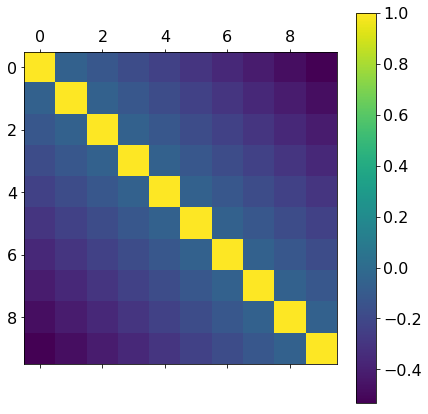

In [7]:
A, *_ = discretize(N=10, lam=0.15)
plt.matshow(A)
plt.colorbar();

### Решение системы
С точки зрения линейной алгебры, решить систему $Ax = b$ &mdash; это то же самое, что и вычислить $x = A^{-1}b$. В вычислительной же линейной алгебре эти две операции отличаются и по числу действий и по устойчивости к накоклению ошибок округления. В данном примере я взял $\lambda = 0.07$, при таком значении начинают проявляться ошибки, связанные с ошибками округления

In [8]:
A, f, uex, x = discretize(N=2000, lam=0.07)
# A, f, uex, x = discretize(N=2000, lam=0.0729122)

In [9]:
%%time
u1 = np.linalg.solve(A, f)

Wall time: 179 ms


Для того, чтобы перемножить две матрицы или матрицу и вектор по правилам линейной алгебры (а не поэлементно, как это принято в numpy массивах) имеется два эквивалентных синтаксиса:
**A.dot(B)** или **A @ B** (начиная с [Python 3.5](https://www.python.org/dev/peps/pep-0465/)).

In [10]:
%%time
u2 = np.linalg.inv(A) @ f

Wall time: 588 ms


А этот код сделает совсем не то &mdash; он размножит вектор **f** до размера матрицы и перемножит их поэлементно

In [11]:
%%time
u3 = np.linalg.inv(A) * f

Wall time: 559 ms


In [12]:
print('Норма невязки (linalg.solve  )', np.linalg.norm(A @ u1 - f))
print('Норма невязки (linalg.inv + @)', np.linalg.norm(A @ u2 - f))
print('Норма невязки (linalg.inv + *)', np.linalg.norm(A @ u3 - f))

Норма невязки (linalg.solve  ) 4.66343045393e-14
Норма невязки (linalg.inv + @) 4.02306512866e-14
Норма невязки (linalg.inv + *) 1028.97368872


Заметим, что точное решение **uex** отличается от решение СЛАУ. Дело в том, что мы *аппроксимировали* исходную задачу, поэтому решение должно отличаться от точного на ошибку аппроксимации.

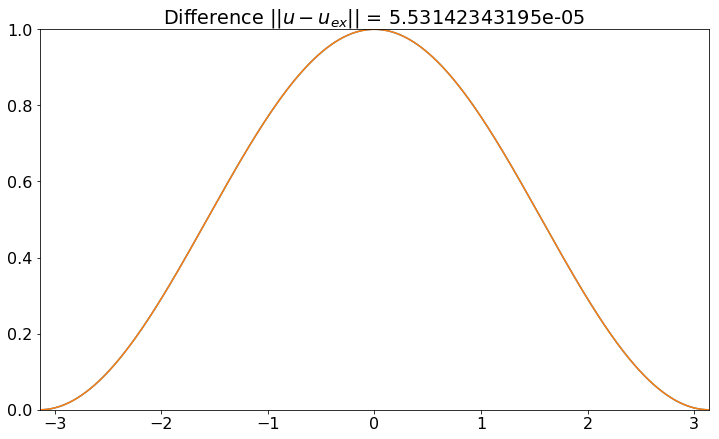

In [13]:
plt.plot(x, u1)
plt.plot(x, uex)
plt.xlim(-np.pi, np.pi)
plt.ylim(0, 1)
plt.title('Difference $||u - u_{ex}||$ = ' + str(np.linalg.norm(u1 - uex)))

<h1 style="color: red">Задание 1</h1>
Интегральное уравнение вырождается при некоторых $\lambda$, в частности, минимальное положительное такое $\lambda$ равно примерно $\lambda_0 = 0.0729122$. При этом задача решения линейной системы становится плохо обусловленой. 

Проведите следующий вычислительный эксперимент:
* Зафиксируйте размер системы, например $N = 1000$
* Возмутите правую часть системы на случайный вектор $\Delta \mathbf f$, $||\Delta \mathbf f|| \sim 10^{-3} ||f||$. Численное решение при этом возмущается на вектор $\Delta \mathbf u$. Оцените число обусловленности системы как
$$
\nu \gtrsim \frac{||\Delta \mathbf u|| / ||\mathbf u||}{||\Delta \mathbf f|| / ||\mathbf f||}
$$
* Постройте log-log график $\nu$ в зависимости от $\lambda_0 - \lambda$. Для этого повторите предыдущий пункт для $\lambda = 0.01 \div \lambda_0$. Рекомендуется взять значения $\lambda$, сгущающиеся к $\lambda_0$. Как растет число обусловленности при приближении к $\lambda_0$?

<h2><span style="color:green">Выполенение задания №1</span></h2>

In [14]:
class NoiseWrapper:
    def __init__(self, func, mu, sigma):
        self.func = func
        self.mu = mu
        self.sigma = sigma
        
    def __call__(self, *args, **kwargs):
        #assumption func = discretize
        A, f, uex, x = self.func(*args, **kwargs)
        f = f * (1 + self.sigma * np.random.randn(*f.shape) + self.mu) 
        return A, f, uex, x

In [15]:
N = 1000
lam = 0.07

A, f, uex, x = discretize(N, lam)
u = np.linalg.solve(A, f)

wrapped_discretize = NoiseWrapper(func=discretize, mu=1e-3, sigma=1e-3)
A, f_noise, uex, x = wrapped_discretize(N, lam)
u_noise = np.linalg.solve(A, f_noise)

nu = np.linalg.norm(u - u_noise) * np.linalg.norm(f) / (np.linalg.norm(u) * np.linalg.norm(f - f_noise))
print('norm[delta f] / norm f = ', np.linalg.norm(f - f_noise) / np.linalg.norm(f))
print('nu = ', nu)

norm[delta f] / norm f =  0.00146191096452
nu =  1.00812083372


In [19]:
lam0 = 0.0729122
eps = 0.01

lams = sorted(lam0 + eps * np.random.normal(size=1000)) #np.linspace(lam0-eps, lam0+eps, 100)
nus = []

for lam in lams:
    A, f, _, _ = discretize(N, lam)
    u = np.linalg.solve(A, f)
    
    A_noise, f_noise, _, _ = wrapped_discretize(N, lam)
    u_noise = np.linalg.solve(A_noise, f_noise)
    nu = np.linalg.norm(u - u_noise) * np.linalg.norm(f) / (np.linalg.norm(u) * np.linalg.norm(f - f_noise))
    
    nus.append(nu)

In [17]:
lams_np = np.array(lams)
nus_np = np.array(nus)

slope =  -0.803106566117
intercept =  -5.28752993497


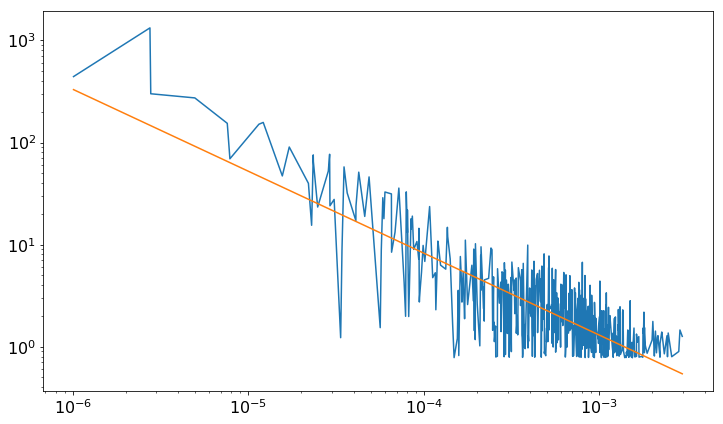

In [20]:
axes = plt.gca()
#axes.set_xlim([None, eps])
x = lams_np[lams_np > lam0] - lam0
y = nus_np[np.where(lams_np > lam0)]
plt.loglog(x, y)

slope, intercept = np.polyfit(np.log(x), np.log(y), 1)
print('slope = ', slope)
print('intercept = ', intercept)

plt.loglog(x, np.exp(slope*np.log(x) + intercept))

$log(\nu) \approx -0.8log(\lambda - \lambda_0) - 5.28$<br>
$\nu \approx \frac{1}{||\lambda - \lambda_0 ||^{0.8}}$

<b>Обусловленной сильно растет при приближении к $\lambda_0$</b>

<h1 style="color: red">Задание 2</h1>
Исследуйте порядок аппроксимации метода. Для этого зафиксируйте $\lambda = 0.05$. Теперь меняя $N = 5 \div 5000$ изучите поведение $||\mathbf u - \mathbf u_{ex}||$, где $\mathbf u_{ex}$ &mdash; точное решение интегрального уравнения, а $\mathbf u$ &mdash; решение аппроксимирующей линейной системы. Для задания набора значений $N$ воспользуйтесь функцией **np.logspace**, округлив результат с помощью **np.int_**: например, так

    np.int_(np.logspace(0.7, 3.7, 10))

<h2><span style="color:green">Выполенение задания №2</span></h2>

In [18]:
N_range = np.int_(np.logspace(0.7, 3.7, 1000))

In [19]:
lam = 0.05

errs = []
for N in N_range:
    A, f, uex, x = discretize(N, lam)
    u = np.linalg.solve(A, f)
    err = np.linalg.norm(u - uex)
    errs.append(err)

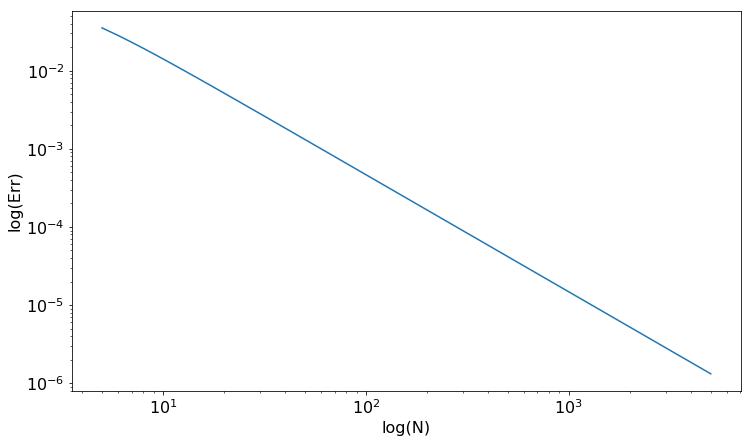

In [20]:
plt.loglog(N_range, errs)
plt.xlabel('log(N)')
plt.ylabel('log(Err)')

In [21]:
slope, intercept = np.polyfit(np.log(N_range), np.log(errs), 1)
print('slope = ', slope)
print('intercept = ', intercept)

slope =  -1.48980694657
intercept =  -0.827165883167


Таким образом, $log(Err) = slope * log(N) + intercept$, <br>
откуда $Err ~= C*N^{-1.5}$.<br>
Так как $h = \frac{L}{N}$, то $Err \propto h^{1.5}$ 

<b>Следовательно, порядок равен 1,5</b> 

### Как устроен np.linalg.solve?

Для решения СЛАУ используется стандартный метод, реализованный во всех уважающих себя библиотеках линейной алгебры: LU разложение. По смыслу, этот метод является матричной интерпретацией метода Гаусса с выбором главного элемента.

При LU разложении матрица представляется в виде
$$
A = P L U,
$$
где $P$ &mdash; матрица перестановки строк (перестановки возникают при выборе главного элемента), $L, U$ &mdash; соответственно, нижне- и верхне- треугольная матрица, причем на диагонали у $L$ стоят единицы.

In [22]:
import scipy.linalg as la

In [23]:
n = 100
A = np.random.rand(n, n)
f = np.random.rand(n)

In [24]:
P, L, U = la.lu(A)

In [25]:
print('Проверка, ||PLU - A|| =', np.linalg.norm((P @ L @ U) - A))

Проверка, ||PLU - A|| = 2.22977239577e-14


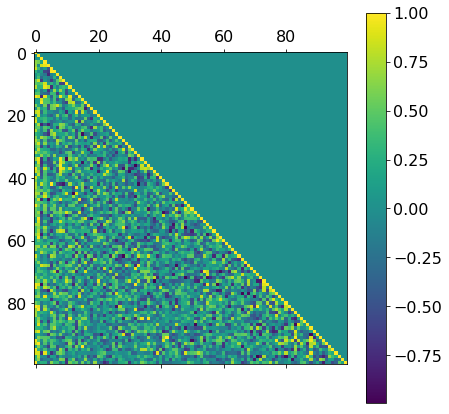

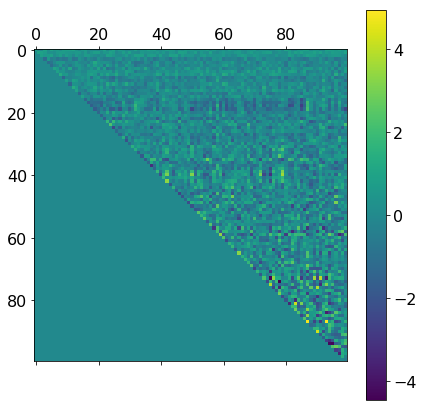

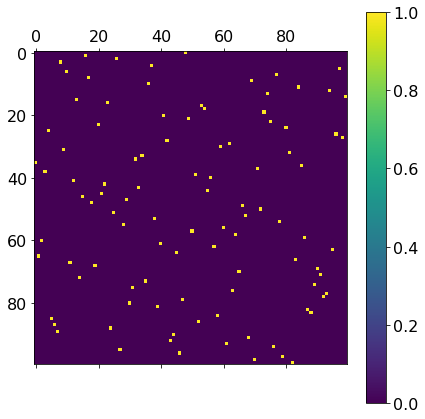

In [26]:
plt.matshow(L)
plt.colorbar()
plt.matshow(U)
plt.colorbar()
plt.matshow(P)
plt.colorbar();

Как же имея LU разложение матрицы вычислить решение системы $Ax = f$? Задача сводится к последовательному решению двух треугольных систем (учтем, что матрица перестановки является ортогональной $P^{-1} = P^\top$):
$$
Ax = f\\
PLUx = f\\
LUx = P^\top f\\
Ly = P^\top f, \qquad Ux = y
$$

In [27]:
y    = la.solve_triangular(L, P.T @ f, lower=True, unit_diagonal=True)
u_lu = la.solve_triangular(U, y      , lower=False)

In [28]:
np.linalg.norm(u_lu - la.solve(A, f))

8.0320664871116201e-14